# 00_temp_data_exploration

This notebook __explores temperature data__ for Monterrey in order to find interesting facts and relations __for further analysis and dissemination.__

## Import libraries

In [1]:
from pathlib import Path

current_path = Path().resolve()

for parent in current_path.parents:
    if parent.name == "accesibilidad-urbana":
        project_root = parent
        break

print(project_root)

/home/observatorio/Documents/repos/accesibilidad-urbana


In [2]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

# Correlation calc
import scipy.stats as stats

from pandas.api.types import CategoricalDtype

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join(project_root))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

## Notebook config

In [59]:
city = 'Guadalajara'
projected_crs = "EPSG:32613"
res = 9

## Load data

### __Load data__ - Temperature

In [60]:
temp_schema = 'raster_analysis'
temp_table = 'temperature_analysis_hex'

query = f"SELECT * FROM {temp_schema}.{temp_table} WHERE \"city\" = '{city}\' AND \"res\" = '{res}\'"
temperature_gdf = aup.gdf_from_query(query, geometry_col='geometry')

infs = temperature_gdf.loc[np.isinf(temperature_gdf['temperature_mean'])]
if len(infs)>0:
    print(f"WARNING: Dropping {len(infs)} hexs res {res} because of inf values.")
    temperature_gdf = temperature_gdf.loc[~np.isinf(temperature_gdf['temperature_mean'])].copy()

# Show
print(temperature_gdf.shape)
temperature_gdf.head(2)

(10189, 17)


,hex_id,geometry,res,temperature_mean,temperature_std,temperature_median,temperature_max,temperature_min,temperature_diff,temperature_tend,temperature_2018,temperature_2019,temperature_2020,temperature_2021,temperature_2022,temperature_2023,city
0,89498c971bbffff,"POLYGON ((-103.29771 20.64594, -103.29649 20.6...",9,38.775168,7.327488,39.003720,47.741815,27.678571,20.063244,0.047917,36.590136,39.144345,39.513951,36.777381,39.775000,39.459686,Guadalajara
1,8949ab4ac63ffff,"POLYGON ((-103.52134 20.76049, -103.52012 20.7...",9,38.728672,10.548178,37.676599,52.620397,24.525194,28.095203,-0.046288,37.511420,42.729651,40.308866,38.482849,36.714099,38.478594,Guadalajara


### __Load data__ - NDVI

In [61]:
ndvi_schema = 'raster_analysis'
ndvi_table = 'ndvi_analysis_hex'

query = f"SELECT * FROM {ndvi_schema}.{ndvi_table} WHERE \"city\" = '{city}\' AND \"res\" = '{res}\'"
ndvi_gdf = aup.gdf_from_query(query, geometry_col='geometry')

infs = ndvi_gdf.loc[np.isinf(ndvi_gdf['ndvi_mean'])]
if len(infs)>0:
    print(f"WARNING: Dropping {len(infs)} hexs res {res} because of inf values.")
    ndvi_gdf = ndvi_gdf.loc[~np.isinf(ndvi_gdf['ndvi_mean'])].copy()

# Show
print(ndvi_gdf.shape)
ndvi_gdf.head(2)

(10192, 17)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndvi_2018,ndvi_2019,ndvi_2020,ndvi_2021,ndvi_2022,ndvi_2023,city
0,89498c96e0bffff,"POLYGON ((-103.35267 20.66765, -103.35145 20.6...",9,0.086146,0.016522,0.090962,0.101136,0.075939,0.025197,-0.000605,0.099052,0.099929,0.092940,0.093442,0.065131,0.066382,Guadalajara
1,8949aa2da73ffff,"POLYGON ((-103.27136 20.59226, -103.27014 20.5...",9,0.215786,0.082892,0.206031,0.328475,0.134408,0.194067,-0.001936,0.287162,0.232900,0.240307,0.238293,0.154813,0.141242,Guadalajara


### __Load data__ - NDMI

In [62]:
ndmi_schema = 'raster_analysis'
ndmi_table = 'ndmi_analysis_hex'

query = f"SELECT * FROM {ndmi_schema}.{ndmi_table} WHERE \"city\" = '{city}\' AND \"res\" = '{res}\'"
ndmi_gdf = aup.gdf_from_query(query, geometry_col='geometry')

infs = ndmi_gdf.loc[np.isinf(ndmi_gdf['ndmi_mean'])]
if len(infs)>0:
    print(f"WARNING: Dropping {len(infs)} hexs res {res} because of inf values.")
    ndmi_gdf = ndmi_gdf.loc[~np.isinf(ndmi_gdf['ndmi_mean'])].copy()

# Show
print(ndmi_gdf.shape)
ndmi_gdf.head(2)

(10192, 17)


,hex_id,geometry,res,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend,ndmi_2018,ndmi_2019,ndmi_2020,ndmi_2021,ndmi_2022,ndmi_2023,city
0,89498c968afffff,"POLYGON ((-103.38612 20.68243, -103.3849 20.68...",9,-0.023509,0.012409,-0.022292,-0.004774,-0.043989,0.039215,0.000103,-0.025587,-0.022148,-0.022587,-0.031277,-0.023739,-0.015716,Guadalajara
1,89498c90b73ffff,"POLYGON ((-103.19688 20.67017, -103.19566 20.6...",9,-0.009180,0.147709,-0.054320,0.233925,-0.167798,0.401722,0.000637,0.027549,-0.054772,-0.018509,-0.005665,-0.002120,-0.001562,Guadalajara


### __Load data__ - Marginalization

In [63]:
marg_schema = 'sociodemografico'
marg_table = 'margurb_inegi_20_ageb_hex'

query = f"SELECT * FROM {marg_schema}.{marg_table} WHERE \"city\" = '{city}\' AND \"res\" = '{res}\'"
marg_gdf = aup.gdf_from_query(query, geometry_col='geometry')

infs = marg_gdf.loc[np.isinf(marg_gdf['imn_2020'])]
if len(infs)>0:
    print(f"WARNING: Dropping {len(infs)} hexs res {res} because of inf values.")
    marg_gdf = marg_gdf.loc[~np.isinf(marg_gdf['ndmi_mean'])].copy()

# Show
print(marg_gdf.shape)
marg_gdf.head(2)

(5878, 14)


,hex_id,res,cvegeo_mun,cve_ent,nom_ent,cve_mun,nom_mun,city,type,pobtot,im_2020,imn_2020,grado_marg,geometry
0,89498c96e0bffff,9,14039,14,Jalisco,039,Guadalajara,Guadalajara,urban,1298.48220,122.984634,0.960710,Bajo,"POLYGON ((-103.35267 20.66765, -103.35145 20.6..."
1,89498c960a3ffff,9,14039,14,Jalisco,039,Guadalajara,Guadalajara,urban,876.05414,122.489044,0.956838,Bajo,"POLYGON ((-103.34713 20.62771, -103.34591 20.6..."


### __Load data__ - Buildings

In [7]:
a="""
# First time (csv to gpkg)

# Read csv
buildings_df = pd.read_csv(str(project_root)+'/data/external/google_open_buildings/843_buildings.csv')
# Convert to gdf
from shapely.wkt import loads
buildings_df["geometry"] = buildings_df["geometry"].apply(loads)
buildings_gdf = gpd.GeoDataFrame(buildings_df, geometry="geometry", crs="EPSG:4326")

# Save
buildings_gdf.to_file(str(project_root)+"/data/external/google_open_buildings/google_buildings_843.gpkg")
"""

In [8]:
# Read previously created gdf
buildings_gdf = gpd.read_file(str(project_root)+"/data/external/google_open_buildings/google_buildings_843.gpkg")           

# Show
print(buildings_gdf.crs)
print(buildings_gdf.shape)
buildings_gdf.head(2)

EPSG:4326
(17536895, 6)


,latitude,longitude,area_in_meters,confidence,full_plus_code,geometry
0,18.364032,-100.670645,60.4298,0.8018,75CX987H+JP97,"MULTIPOLYGON (((-100.67059 18.36404, -100.6706..."
1,20.446907,-103.526685,10.5973,0.7524,75GRCFWF+Q886,"MULTIPOLYGON (((-103.52667 20.44689, -103.5266..."


## __Analysis 1__ - Tendencia por año de temperatura, NDVI y NDMI

In [64]:
# Temperature data years
temp_data_years = ['temperature_2018', 'temperature_2019', 'temperature_2020', 'temperature_2021', 'temperature_2022', 'temperature_2023']
# Aggregate statistics
temp_stats = temperature_gdf[temp_data_years].agg(['min', 'mean', 'median', 'std', 'max'])
temp_stats.rename(columns={'temperature_2018':'2018',
                           'temperature_2019':'2019',
                           'temperature_2020':'2020',
                           'temperature_2021':'2021',
                           'temperature_2022':'2022',
                           'temperature_2023':'2023'},inplace=True)
# Transpose data
temp_stats_transposed = temp_stats.transpose()
temp_stats_transposed.drop(columns=['std'],inplace=True)

# Show
temp_stats_transposed

,min,mean,median,max
2018,19.929292,34.872523,35.243157,41.966188
2019,23.600301,38.971530,39.071221,49.900000
2020,24.620772,37.732371,38.139409,45.022214
2021,22.726807,36.370615,36.580952,44.879217
2022,23.643445,36.981415,37.428125,44.923958
2023,24.172919,37.742340,38.140693,46.012175


In [65]:
# NDVI data years
ndvi_data_years = ['ndvi_2018', 'ndvi_2019', 'ndvi_2020', 'ndvi_2021', 'ndvi_2022', 'ndvi_2023']
# Aggregate statistics
ndvi_stats = ndvi_gdf[ndvi_data_years].agg(['min', 'mean', 'median', 'std', 'max'])
ndvi_stats.rename(columns={'ndvi_2018':'2018',
                           'ndvi_2019':'2019',
                           'ndvi_2020':'2020',
                           'ndvi_2021':'2021',
                           'ndvi_2022':'2022',
                           'ndvi_2023':'2023'},inplace=True)
# Transpose data
ndvi_stats_transposed = ndvi_stats.transpose()
ndvi_stats_transposed.drop(columns=['std'],inplace=True)

# Show
ndvi_stats_transposed

,min,mean,median,max
2018,-0.076981,0.337351,0.349008,0.815898
2019,0.010430,0.287668,0.286478,0.788813
2020,0.002539,0.315204,0.326052,0.806021
2021,-0.149425,0.307970,0.322192,0.797563
2022,0.000461,0.206524,0.215645,0.595590
2023,0.007340,0.187025,0.193881,0.553505


In [66]:
# NDMI data years
ndmi_data_years = ['ndmi_2018', 'ndmi_2019', 'ndmi_2020', 'ndmi_2021', 'ndmi_2022', 'ndmi_2023']
# Aggregate statistics
ndmi_stats = ndmi_gdf[ndmi_data_years].agg(['min', 'mean', 'median', 'std', 'max'])
ndmi_stats.rename(columns={'ndmi_2018':'2018',
                           'ndmi_2019':'2019',
                           'ndmi_2020':'2020',
                           'ndmi_2021':'2021',
                           'ndmi_2022':'2022',
                           'ndmi_2023':'2023'},inplace=True)
# Transpose data
ndmi_stats_transposed = ndmi_stats.transpose()
ndmi_stats_transposed.drop(columns=['std'],inplace=True)

# Show
ndmi_stats_transposed

,min,mean,median,max
2018,-0.172634,-0.010806,-0.021186,0.842616
2019,-0.216128,-0.044372,-0.051586,0.672123
2020,-0.163650,-0.015190,-0.025377,0.784518
2021,-0.161229,-0.014145,-0.021657,0.768854
2022,-0.137247,-0.010667,-0.015762,0.362333
2023,-0.131094,-0.010896,-0.016573,0.288621


Text(0, 0.5, 'Mean NDMI')

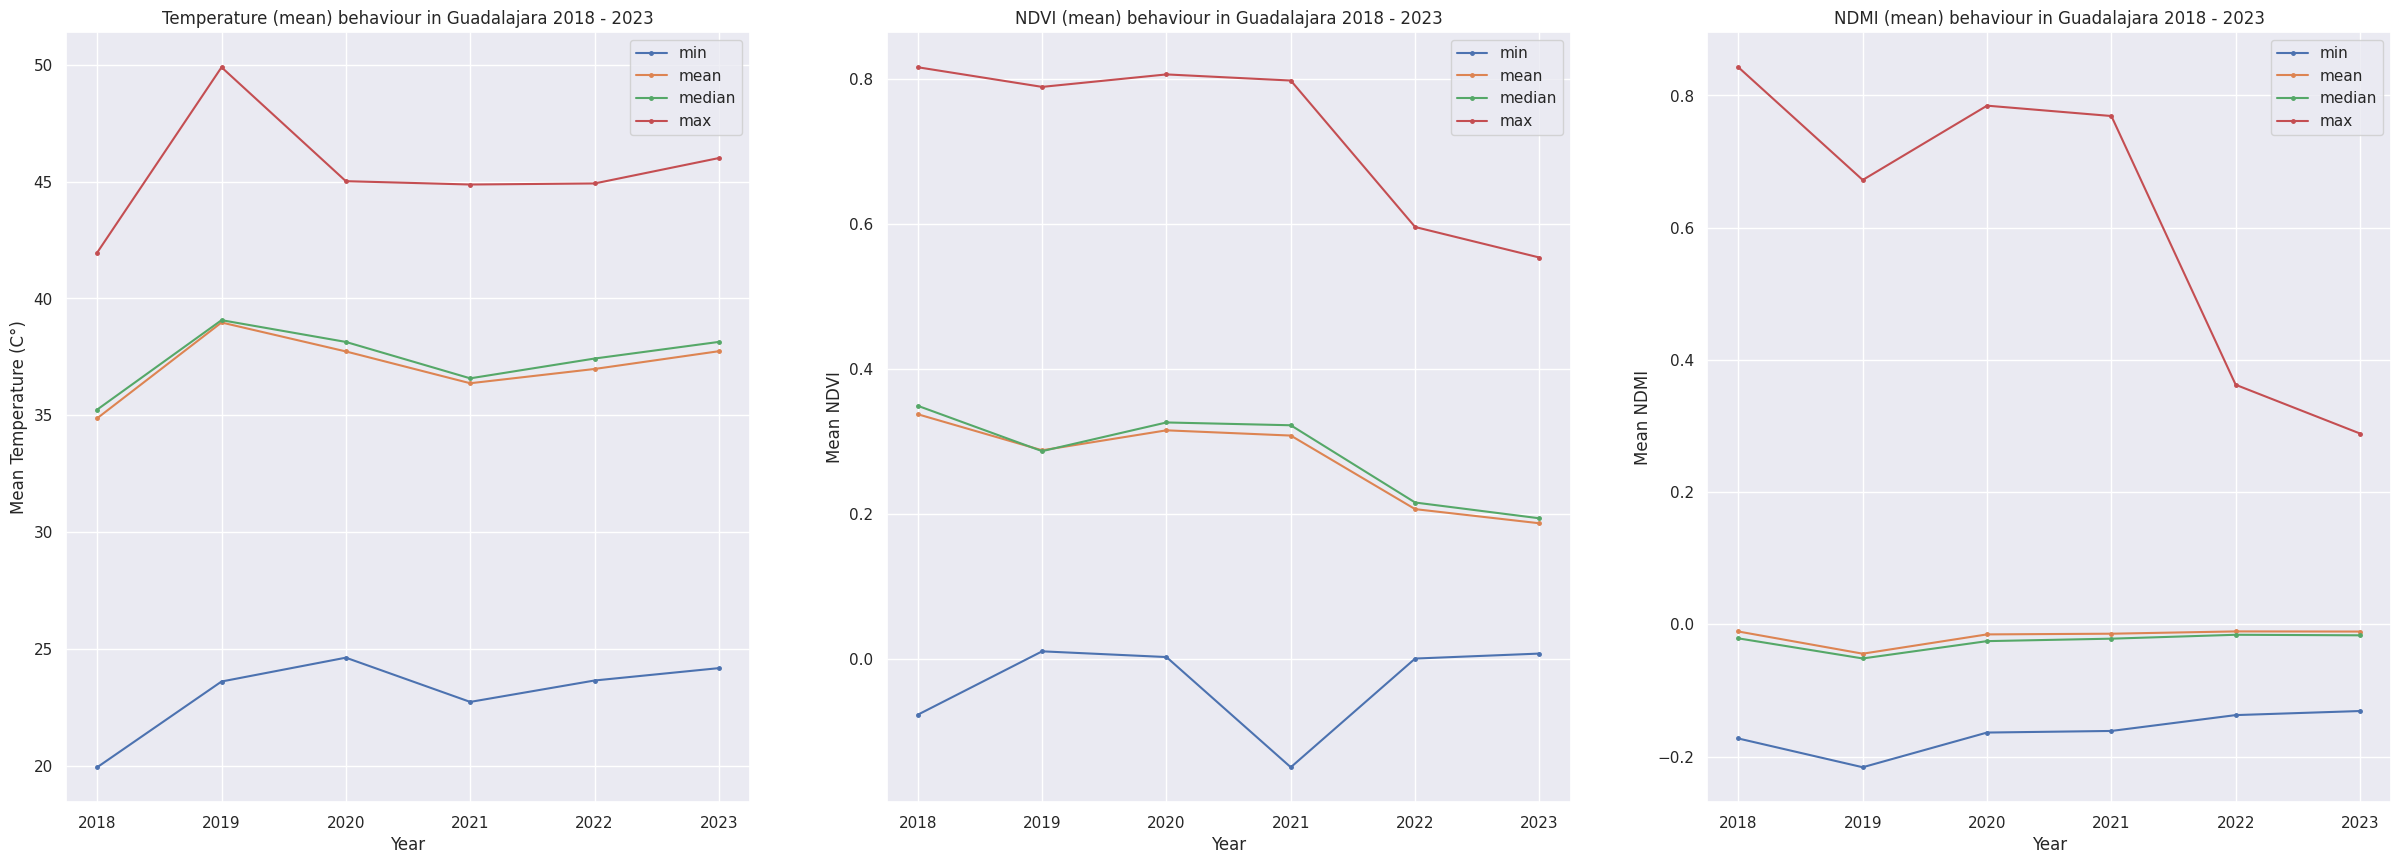

In [68]:
fig, axs = plt.subplots(1,3,figsize=(30,10))

# ---------- PLOT ----------
temp_stats_transposed.plot(style='-o', linewidth = 1.5,markersize=2.5,ax=axs[0])
ndvi_stats_transposed.plot(style='-o', linewidth = 1.5,markersize=2.5,ax=axs[1])
ndmi_stats_transposed.plot(style='-o', linewidth = 1.5,markersize=2.5,ax=axs[2])

# ---------- FORMAT ----------
# Format - Main titles
axs[0].set_title(f'Temperature (mean) behaviour in {city} 2018 - 2023')
axs[1].set_title(f'NDVI (mean) behaviour in {city} 2018 - 2023')
axs[2].set_title(f'NDMI (mean) behaviour in {city} 2018 - 2023')

# Format - Axis titles
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Mean Temperature (C°)')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Mean NDVI')
axs[2].set_xlabel('Year')
axs[2].set_ylabel('Mean NDMI')

### __Conclusion:__ Needs more data to establish posible tendency, but would be more interesting to see graph by month with overall tendency.

## __Analysis 2__ - Correlations

### __Preparation for correlation analysis:__ Add Temperature anomaly (hex mean - city mean) and NDVI (Mean value)

In [69]:
# Merge temp and ndvi
exploration_gdf_1 = pd.merge(temperature_gdf[['hex_id','temperature_mean']],ndvi_gdf[['hex_id','ndvi_mean']],on='hex_id')

# Temperature - Calculate anomaly (differential between mean in each hex and city mean)
mean_city_temperature = exploration_gdf_1.temperature_mean.mean()
print(f"Mean temperature in {city}: {mean_city_temperature}.")
exploration_gdf_1['temperature_anomaly'] = exploration_gdf_1['temperature_mean'] - mean_city_temperature
exploration_gdf_1.drop(columns=['temperature_mean'],inplace=True)

# NDVI - Calculate anomaly (differential between mean in each hex and city mean)
#mean_city_ndvi = exploration_gdf_1.ndvi_mean.mean()
#print(f"Mean NDVI in {city}: {mean_city_ndvi}.")
#exploration_gdf_1['ndvi_anomaly'] = exploration_gdf_1['ndvi_mean'] - mean_city_ndvi

# Show
print(exploration_gdf_1.shape)
exploration_gdf_1.head(2)

Mean temperature in Guadalajara: 37.12298346912245.
(10189, 3)


,hex_id,ndvi_mean,temperature_anomaly
0,89498c971bbffff,0.126141,1.652185
1,8949ab4ac63ffff,0.337590,1.605688


In [70]:
# TWO-VARIABLE CORRELATION GRAPH
a="""
gdf = exploration_gdf_1.copy()
i = 'ndvi_anomaly'
j = 'temperature_anomaly'

fig,ax = plt.subplots()

# Calculate corr
corr, pval = stats.pearsonr(gdf[i],gdf[j])

# Correlation categories
abs_corr = abs(corr)
if abs_corr > 0.80:
    corr_cat = 'Very strong'
    color='darkgreen'
elif (abs_corr<0.80) and (abs_corr>0.60):
    corr_cat = 'Strong'
    color = 'yellowgreen'
elif (abs_corr<0.60) and (abs_corr>0.40):
    corr_cat = 'Moderate'
    color = 'orange'
else:
    corr_cat = 'Weak/very weak'
    color = 'red'

# Plot scatter
ax.scatter(gdf[i], gdf[j], s=5,zorder=0)

# Linear regresion
m, b = np.polyfit(gdf[i], gdf[j], 1)
ax.plot(gdf[i], m*gdf[i] + b, color="red", linestyle="--", label="Trend line",zorder=1)

# Quadratic regresian
coef = np.polyfit(gdf[i], gdf[j], 2) # a*x^2 + b*x + c coeficients
p = np.poly1d(coef) #Helps create curve
# X and Y values based on previous regresion
x_fit = np.linspace(gdf[i].min(), gdf[i].max(), 100) # Rango de X
y_fit = p(x_fit)
# Plot
ax.plot(x_fit, y_fit, color="black", linestyle="--", label="Quadratic trend",zorder=2)

# ---------- FORMAT ----------
# Format - Main title
#plt.title(f"""
#Temperature and NDVI in {city}.
#{corr_cat} corr = {round(corr, 4)}""",fontsize=10,color=color)

# Format - Axis titles
#plt.xlabel("NDVI diferential with city's mean")
#plt.ylabel("Temperature diferential with city's mean (C°)")

### __Preparation for correlation analysis:__ Add NDMI diff

In [71]:
# Add NDMI to exploration_gdf
exploration_gdf_2 = pd.merge(exploration_gdf_1,ndmi_gdf[['hex_id','ndmi_diff']],on='hex_id')

# NDMI - Calculate anomaly (differential between mean in each hex and city mean)
#mean_city_ndmi = exploration_gdf_2.ndmi_mean.mean()
#print(f"Mean NDMI in {city}: {mean_city_ndmi}.")
#exploration_gdf_2['ndmi_anomaly'] = exploration_gdf_2['ndmi_mean'] - mean_city_ndmi

# Show
print(exploration_gdf_2.shape)
exploration_gdf_2.head(2)

(10189, 4)


,hex_id,ndvi_mean,temperature_anomaly,ndmi_diff
0,89498c971bbffff,0.126141,1.652185,0.032792
1,8949ab4ac63ffff,0.337590,1.605688,0.373990


### __Preparation for correlation analysis:__ Add Marg.

In [72]:
# Add Marg. to exploration_gdf
exploration_gdf_3 = pd.merge(exploration_gdf_2,marg_gdf[['hex_id','imn_2020']],on='hex_id')

# Marg. - Calculate anomaly (differential between mean in each hex and city mean)
#mean_city_ndmi = exploration_gdf_3.ndmi_mean.mean()
#print(f"Mean NDMI in {city}: {mean_city_ndmi}.")
#exploration_gdf_2['ndmi_anomaly'] = exploration_gdf_2['ndmi_mean'] - mean_city_ndmi

# Show
print(exploration_gdf_3.shape)
exploration_gdf_3.head(2)

(5876, 5)


,hex_id,ndvi_mean,temperature_anomaly,ndmi_diff,imn_2020
0,89498c971bbffff,0.126141,1.652185,0.032792,0.970478
1,89498c94837ffff,0.144083,0.443948,0.051930,0.940274


### __Preparation for correlation analysis:__ Add Built area (Google Buildings)

In [73]:
# Isolate hexs
hex_gdf = temperature_gdf[['hex_id', 'geometry']].copy()

# Split buildings using the hexs
buildings_split = gpd.overlay(buildings_gdf, hex_gdf, how='intersection')

# Calculate cut area of each building
if buildings_split.crs != projected_crs:
    buildings_split.to_crs(projected_crs,inplace=True)
    print(f"Changed buildings_split crs to {projected_crs}.")    
buildings_split['built_area'] = buildings_split.geometry.area

# Sum built area by hex
hex_building_areas = buildings_split.groupby('hex_id')['built_area'].sum().reset_index()

# Join with geom
hex_gdf = hex_gdf.merge(hex_building_areas, on='hex_id', how='left')
hex_gdf['built_area'] = hex_gdf['built_area'].fillna(0)

# Show
print(hex_gdf.built_area.sum())
print(hex_gdf.crs)
print(hex_gdf.shape)
hex_gdf.head(2)

Changed buildings_split crs to EPSG:32613.
204091863.56574914
EPSG:4326
(10189, 3)


,hex_id,geometry,built_area
0,89498c971bbffff,"POLYGON ((-103.29771 20.64594, -103.29649 20.6...",60524.092797
1,8949ab4ac63ffff,"POLYGON ((-103.52134 20.76049, -103.52012 20.7...",3943.661532


In [74]:
# Add buildings to exploration_gdf
exploration_gdf_4 = pd.merge(exploration_gdf_3,hex_gdf[['hex_id','built_area']],on='hex_id')

# Built area - Calculate anomaly (differential between mean in each hex and city mean)
#mean_city_builtarea = exploration_gdf_3.built_area.mean()
#print(f"Mean built_area in {city}: {round(mean_city_builtarea,0)} m2.")
#exploration_gdf_3['built_area_anomaly'] = exploration_gdf_3['built_area'] - mean_city_builtarea

# Show
print(exploration_gdf_4.shape)
exploration_gdf_4.head(2)

(5876, 6)


,hex_id,ndvi_mean,temperature_anomaly,ndmi_diff,imn_2020,built_area
0,89498c971bbffff,0.126141,1.652185,0.032792,0.970478,60524.092797
1,89498c94837ffff,0.144083,0.443948,0.051930,0.940274,53144.207207


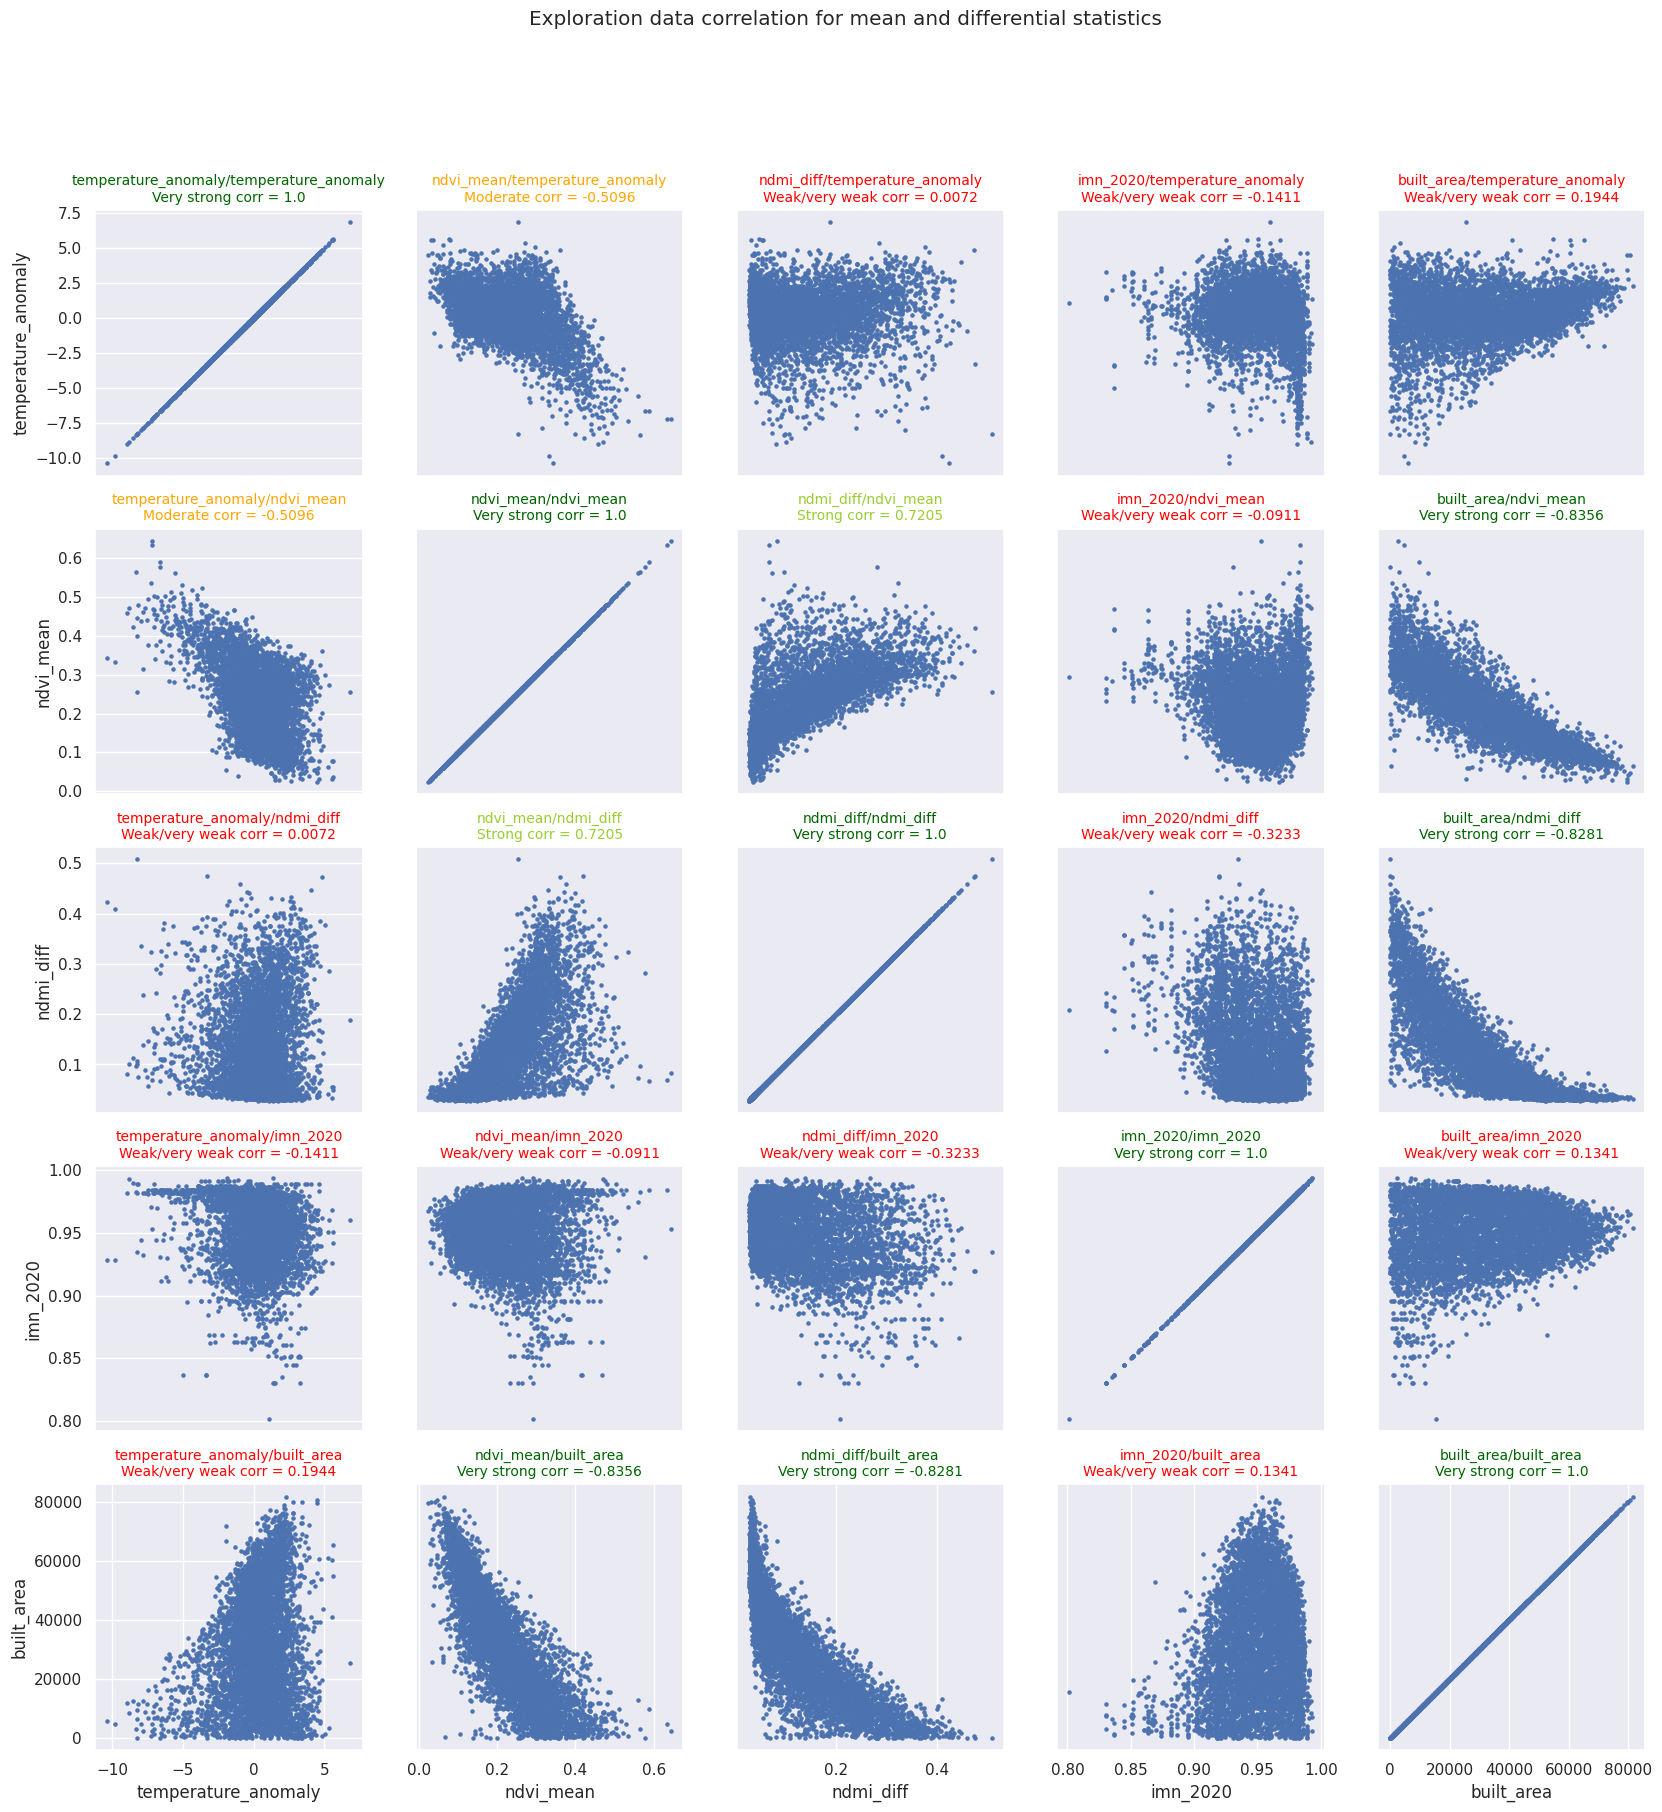

In [75]:
data_gdf = exploration_gdf_4.copy()

# Subplots grid with n by n combinations (6 data, 6x6)
summary_cols = ['temperature_anomaly','ndvi_mean','ndmi_diff','imn_2020','built_area']
fig, axs = plt.subplots(len(summary_cols), len(summary_cols), figsize=(20,20))
fig.suptitle('Exploration data correlation for mean and differential statistics')

# For each col combination
for i in range(len(summary_cols)):

    # For each row
    for j in range(len(summary_cols)):
        
        #Plot scatter
        axs[i,j].scatter(data_gdf[summary_cols[j]], data_gdf[summary_cols[i]], s=5)

        #Correlation
        corr, pval = stats.pearsonr(data_gdf[summary_cols[j]],data_gdf[summary_cols[i]])
        
        # Correlation categories
        abs_corr = abs(corr)
        if abs_corr > 0.80:
            corr_cat = 'Very strong'
            color='darkgreen'
        elif (abs_corr<0.80) and (abs_corr>0.60):
            corr_cat = 'Strong'
            color = 'yellowgreen'
        elif (abs_corr<0.60) and (abs_corr>0.40):
            corr_cat = 'Moderate'
            color = 'orange'
        else:
            corr_cat = 'Weak/very weak'
            color = 'red'

        # Set title with correlation categories and corr data
        axs[i,j].set_title(f"""{summary_cols[j].replace('_count','')}/{summary_cols[i].replace('_count','')}
{corr_cat} corr = {round(corr, 4)}""",fontsize=10,color=color)

        # Format - Turn off tick marks
        axs[i,j].get_xaxis().set_visible(False)
        axs[i,j].get_yaxis().set_visible(False)

        # Format - Turn on last row/col tick marks and set used col label
        if i == len(summary_cols) - 1:
            axs[i,j].get_xaxis().set_visible(True)
            axs[i,j].set_xlabel(summary_cols[j])

        if j == 0:
            axs[i,j].get_yaxis().set_visible(True)
            axs[i,j].set_ylabel(summary_cols[i])

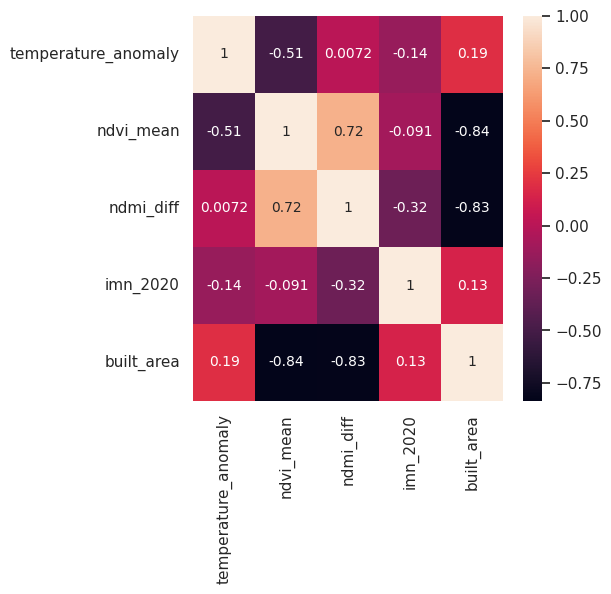

In [82]:
# Isolate data of interest
data_gdf_iso = data_gdf[summary_cols].copy()
# Create correlation heatmap
sns.heatmap(data_gdf_iso.corr(), annot =True, annot_kws={"fontsize":10} )
# Seaborn plot format
sns.set(rc = {'figure.figsize':(5,5)})
# Show
plt.show()